In [136]:
# import the modules

import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
scorer = make_scorer(mean_squared_error, greater_is_better = False)
from textblob import *

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
#from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /home/roott/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [137]:

nltk.download("stopwords")
from nltk.corpus import stopwords
# print (set(stopwords.words('english')))

from string import punctuation
#print (list(punctuation))

custom_set_of_stopwords = set(stopwords.words('english')+list(punctuation))
len(custom_set_of_stopwords)

[nltk_data] Downloading package stopwords to /home/roott/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


211

### Loading Train Data

In [138]:
train = pd.read_csv('Train.csv')
train = train.drop(['id','host_id','host_name'],1)
train.head()

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Large private room in Nolita,Manhattan,Nolita,40.72217,-73.99481,Private room,120,7,3,2015-09-01,0.06,3,0
1,Super Bowl New York City Apartment,Manhattan,Upper West Side,40.80020,-73.96045,Entire home/apt,1500,1,0,NaN,NaN,1,0
2,COZY APT CLOSE TO LGA & JFK AND TRANSPORTATION,Queens,East Elmhurst,40.75558,-73.89316,Entire home/apt,200,2,4,2019-07-05,4.00,1,365
3,Stream-Pressed Paradise (Laundry Room Setup),Staten Island,Concord,40.60110,-74.07830,Shared room,30,2,0,NaN,NaN,4,82
4,Charming Harlem apartment,Manhattan,Harlem,40.81022,-73.94266,Shared room,115,1,16,2019-05-26,0.27,1,365


# EDA

In [139]:
train.shape
train.info()

train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34226 entries, 0 to 34225
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            34214 non-null  object 
 1   neighbourhood_group             34226 non-null  object 
 2   neighbourhood                   34226 non-null  object 
 3   latitude                        34226 non-null  float64
 4   longitude                       34226 non-null  float64
 5   room_type                       34226 non-null  object 
 6   price                           34226 non-null  int64  
 7   minimum_nights                  34226 non-null  int64  
 8   number_of_reviews               34226 non-null  int64  
 9   last_review                     27244 non-null  object 
 10  reviews_per_month               27244 non-null  float64
 11  calculated_host_listings_count  34226 non-null  int64  
 12  availability_365                

name                                12
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       6982
reviews_per_month                 6982
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [140]:
train.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,34226.000000,34226.000000,34226.000000,34226.000000,34226.000000,27244.000000,34226.000000,34226.000000
mean,40.729059,-73.952070,153.480979,6.953690,23.390931,1.377074,7.093905,113.301730
std,0.054604,0.046161,243.312608,20.255833,44.476822,1.688953,32.828412,131.892814
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690040,-73.983150,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.722995,-73.955700,107.000000,2.000000,5.000000,0.730000,1.000000,45.000000
75%,40.763200,-73.935982,175.000000,5.000000,24.000000,2.020000,2.000000,229.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


### Price column is highly skewed

### checking if last_review and reviews_per_month are null at the same rows, to confirm there were no reviews at all for those properties


In [141]:
nulls = train[train['last_review'].isnull() & train['reviews_per_month'].isnull()]

nulls.head()


,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
1,Super Bowl New York City Apartment,Manhattan,Upper West Side,40.80020,-73.96045,Entire home/apt,1500,1,0,NaN,NaN,1,0
3,Stream-Pressed Paradise (Laundry Room Setup),Staten Island,Concord,40.60110,-74.07830,Shared room,30,2,0,NaN,NaN,4,82
7,Bright Luxury Apartment with Amazing View of City,Brooklyn,Fort Greene,40.69064,-73.97898,Entire home/apt,200,5,0,NaN,NaN,1,0
10,Private room for 2 in cool BK apt,Brooklyn,Kensington,40.64469,-73.97086,Private room,50,14,0,NaN,NaN,1,0
39,LUXURY DELUXE 2BR 2BATH -DOORMAN/GYM,Manhattan,Hell's Kitchen,40.76182,-73.99771,Entire home/apt,550,30,0,NaN,NaN,65,360


### Filling reviews_per_month null values with 0 and imputing last_review columns with null values with the earliest date present in the column

In [142]:
train['reviews_per_month'] = train['reviews_per_month'].fillna(0)
train['last_review'] = train['last_review'].fillna('2011-03-23')

### Binning is done on minimum_nights 

In [143]:
buckets = [0,7, 14,30, 60, 120, 240, train.minimum_nights.max()]
labels = [1,2,3,4, 5, 6, 7]
train['minimum_nights_buckets'] = pd.cut(train['minimum_nights'], bins=buckets, labels=labels)

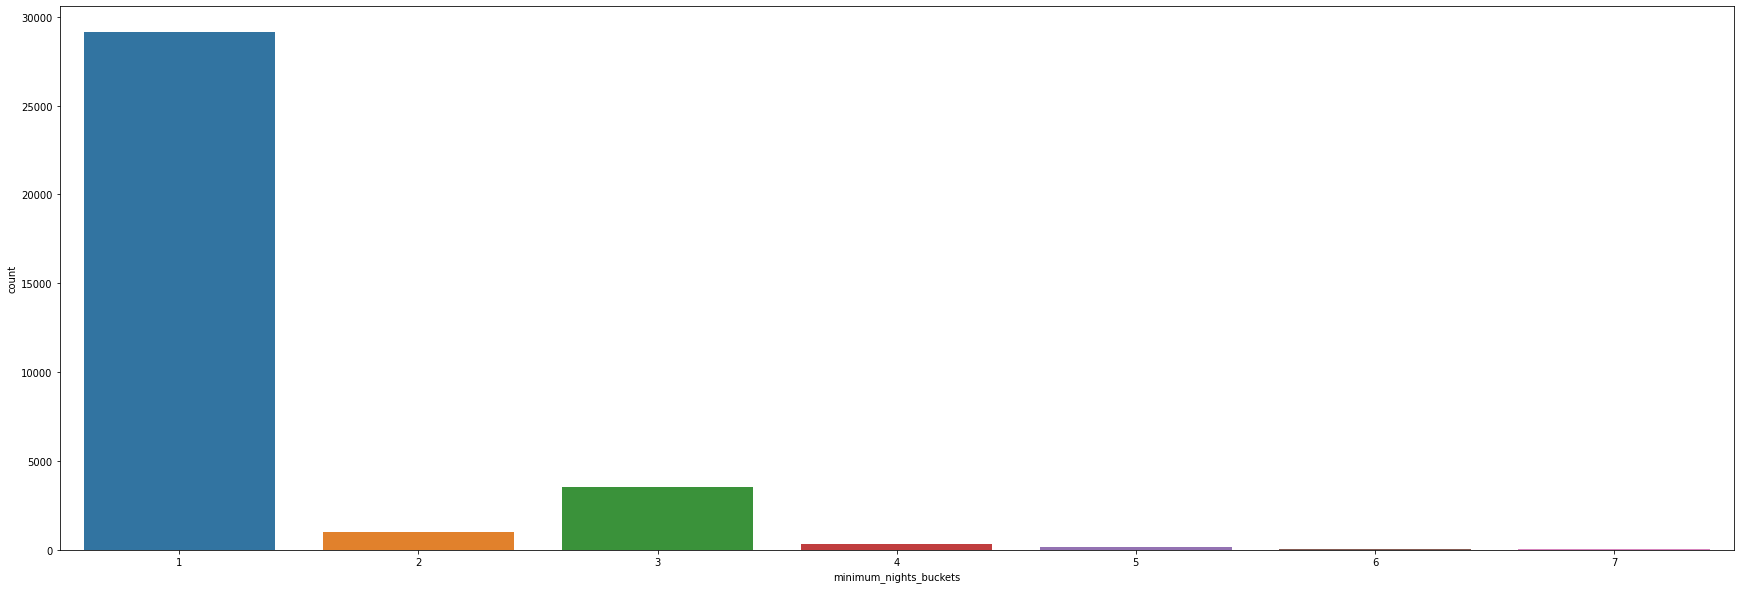

In [144]:
plt.figure(figsize=(30,10))
ax = sns.countplot(x="minimum_nights_buckets", data=train)

### Insight: 1-7 nights bookings are maximum bookings , second hightest booking is for 14-30 nights

<AxesSubplot:xlabel='minimum_nights_buckets', ylabel='count'>

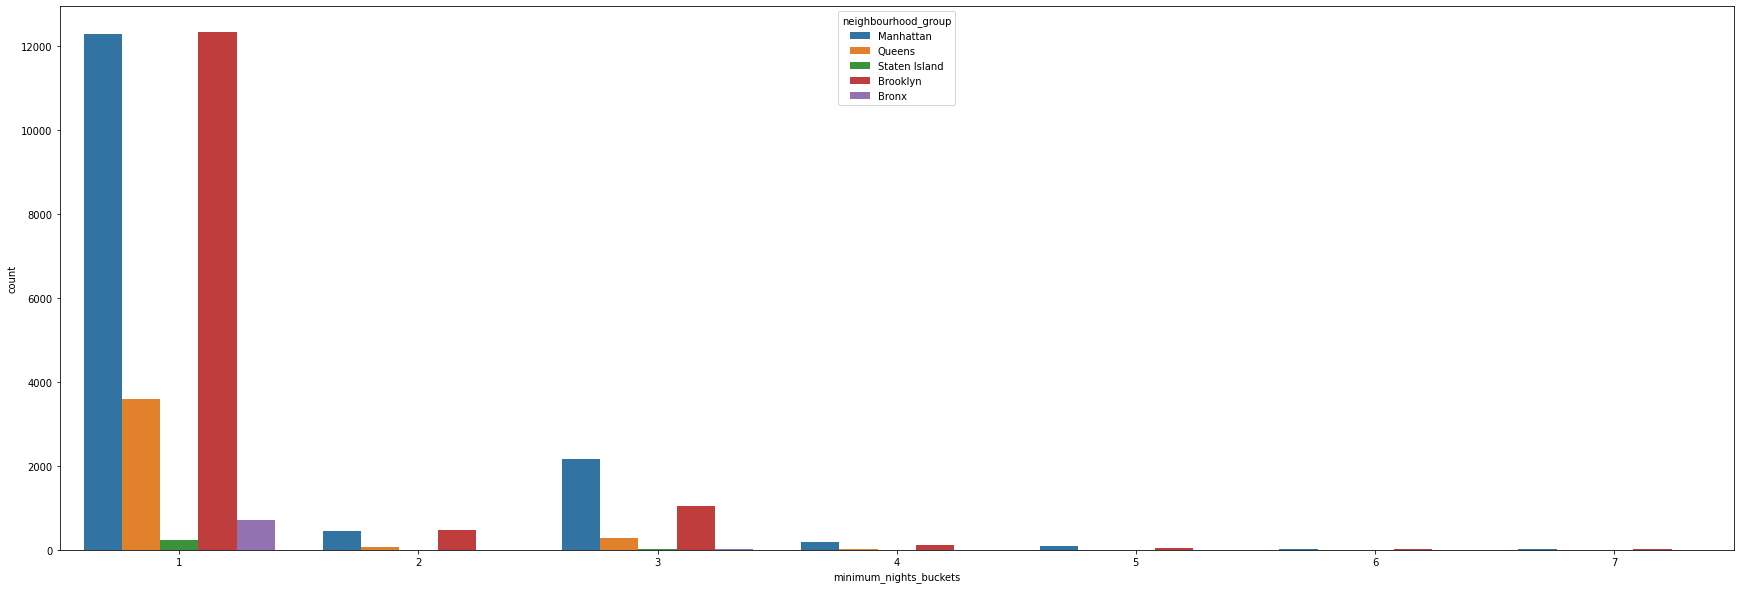

In [145]:
plt.figure(figsize=(30,10))
sns.countplot(x= 'minimum_nights_buckets',hue='neighbourhood_group', data = train)

### Insight: neighbourhood group 'Brooklyn' and 'Manhatten' has got most bookings for 1-7 nights

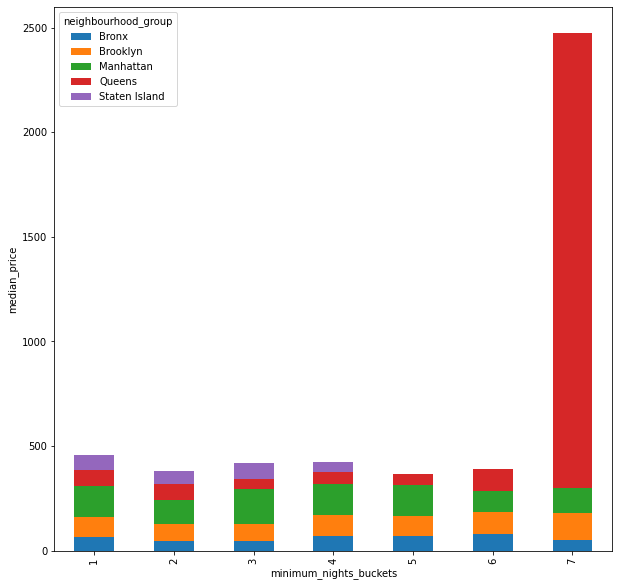

In [146]:
train.groupby(['minimum_nights_buckets', 'neighbourhood_group'])['price'].median().unstack().plot(kind='bar', stacked = True, figsize = (10,10))
plt.ylabel('median_price')
plt.show()

### adding a new columns 'days_last_review', to get days past since last review.

In [147]:
import datetime as dt

train['days_last_review'] = (pd.DatetimeIndex(train['last_review']) - pd.to_datetime('2011-03-23')).astype('str')
train['days_last_review'] = (train['days_last_review'].apply(lambda x : x.split(" ")[0]))


### Converting Latitude and Longitude columns into distance column and finally dropping Latitude and Longitude columns.

In [148]:
# The math module contains a function named
# radians which converts from degrees to radians.

from math import radians, cos, sin, asin, sqrt
def distance(lati1, lati2, long1, long2):
   
  long1 = radians(long1)
  long2 = radians(long2)
  lati1 = radians(lati1)
  lati2 = radians(lati2)
   
  # Haversine formula
  dlong = long2 - long1
  dlati = lati2 - lati1
  a = sin(dlati / 2)**2 + cos(lati1) * cos(lati2) * sin(dlong / 2)**2

  c = 2 * asin(sqrt(a))
 
  # Radius of earth in kilometers. Use 3956 for miles
  r = 6371
   
  # calculate the result
  return(c * r)
# print(distance(lati1, lati2, long1, long2), "K.M")
lati2 =round(train.latitude.values.mean(),2)
long2=round(train.longitude.values.mean(),2)
dist= []
for index,row in train.iterrows():
#     distance(row.latitude,lat2,row.longitude,lon2)
   dist.append(distance(row.latitude,lati2,row.longitude,long2))

#distance =distance(df.latitude.values,lat2,  df.longitude.values, df.longitude.values.mean())
train['distance']= pd.Series(dist)
train['distance'] = round(train['distance'],2)


### Dropping 'last_review','longitude','latitude' columns

In [149]:
train = train.drop(['last_review','longitude','latitude'],1)
train.head()

,name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,minimum_nights_buckets,days_last_review,distance
0,Large private room in Nolita,Manhattan,Nolita,Private room,120,7,3,0.06,3,0,1,1623,3.88
1,Super Bowl New York City Apartment,Manhattan,Upper West Side,Entire home/apt,1500,1,0,0.00,1,0,1,0,7.86
2,COZY APT CLOSE TO LGA & JFK AND TRANSPORTATION,Queens,East Elmhurst,Entire home/apt,200,2,4,4.00,1,365,1,3026,5.57
3,Stream-Pressed Paradise (Laundry Room Setup),Staten Island,Concord,Shared room,30,2,0,0.00,4,82,1,0,17.96
4,Charming Harlem apartment,Manhattan,Harlem,Shared room,115,1,16,0.27,1,365,1,2986,8.94


### Done some basic NLP task on the name column to remove uwanted words and remove punctuation etc.

In [150]:
train = train[train['name'].notnull()]

<Figure size 720x360 with 0 Axes>

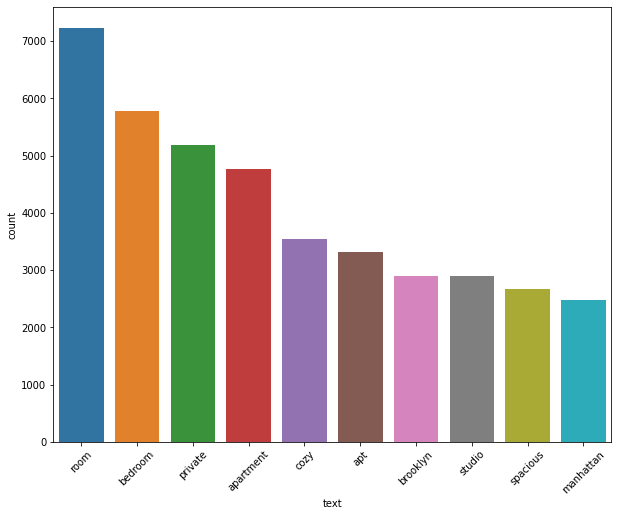

In [151]:
from sklearn.feature_extraction.text import CountVectorizer

def top_n_ngram(corpus,n = None,ngram = 1):
    vec = CountVectorizer(stop_words = 'english',ngram_range=(ngram,ngram)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis =0) #Calculates the count of all the word in the whole review
    words_freq = [(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq,key = lambda x:x[1],reverse = True)
    return words_freq[:n]
common_words = top_n_ngram(train['name'], 10,1)
df = pd.DataFrame(common_words, columns = ['text', 'count'])
plt.figure(figsize =(10,5))
plt.figure(figsize=(10,8))
sns.barplot(x = 'text', y = 'count', data = df )
plt.xticks(rotation = 45)
plt.title='Top 20 words in name column'
plt.show()

In [152]:
train['name'] = train['name'].str.lower()

import string

def remove_punctuation(text):
    no_punct = "".join([c for c in text if c not in string.punctuation])
    return no_punct

train['name'] = train['name'].apply(lambda x:remove_punctuation(x))

def tok(text):
    tokenizer = word_tokenize(text)
    return tokenizer

train['name'] = train['name'].apply(lambda x:tok(x))    

def remove_stop_words(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

train['name'] = train['name'].apply(lambda x:remove_stop_words(x))

def join(text):
    joined = " ".join(text)
    return joined

train['name'] = train['name'].apply(lambda x:join(x))
train.head()


,name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,minimum_nights_buckets,days_last_review,distance
0,large private room nolita,Manhattan,Nolita,Private room,120,7,3,0.06,3,0,1,1623,3.88
1,super bowl new york city apartment,Manhattan,Upper West Side,Entire home/apt,1500,1,0,0.00,1,0,1,0,7.86
2,cozy apt close lga jfk transportation,Queens,East Elmhurst,Entire home/apt,200,2,4,4.00,1,365,1,3026,5.57
3,streampressed paradise laundry room setup,Staten Island,Concord,Shared room,30,2,0,0.00,4,82,1,0,17.96
4,charming harlem apartment,Manhattan,Harlem,Shared room,115,1,16,0.27,1,365,1,2986,8.94


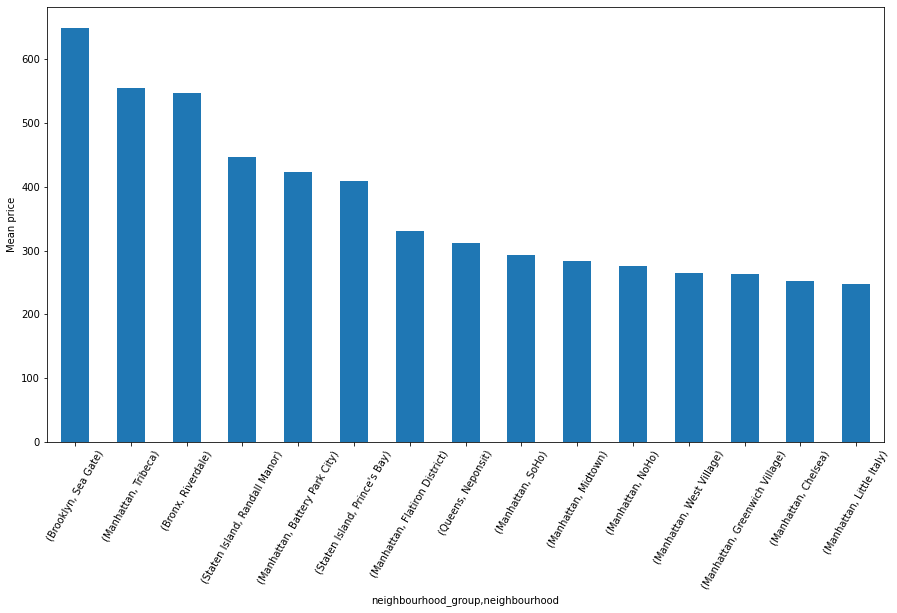

In [153]:
train.groupby(['neighbourhood_group'])['neighbourhood'].nunique()

plt.figure(figsize= (15,8))
data = train.groupby(['neighbourhood_group', 'neighbourhood'])['price'].mean().sort_values(ascending = False)[:15].plot(kind='bar')
plt.xticks(rotation = 60)
plt.ylabel('Mean price')
plt.show()

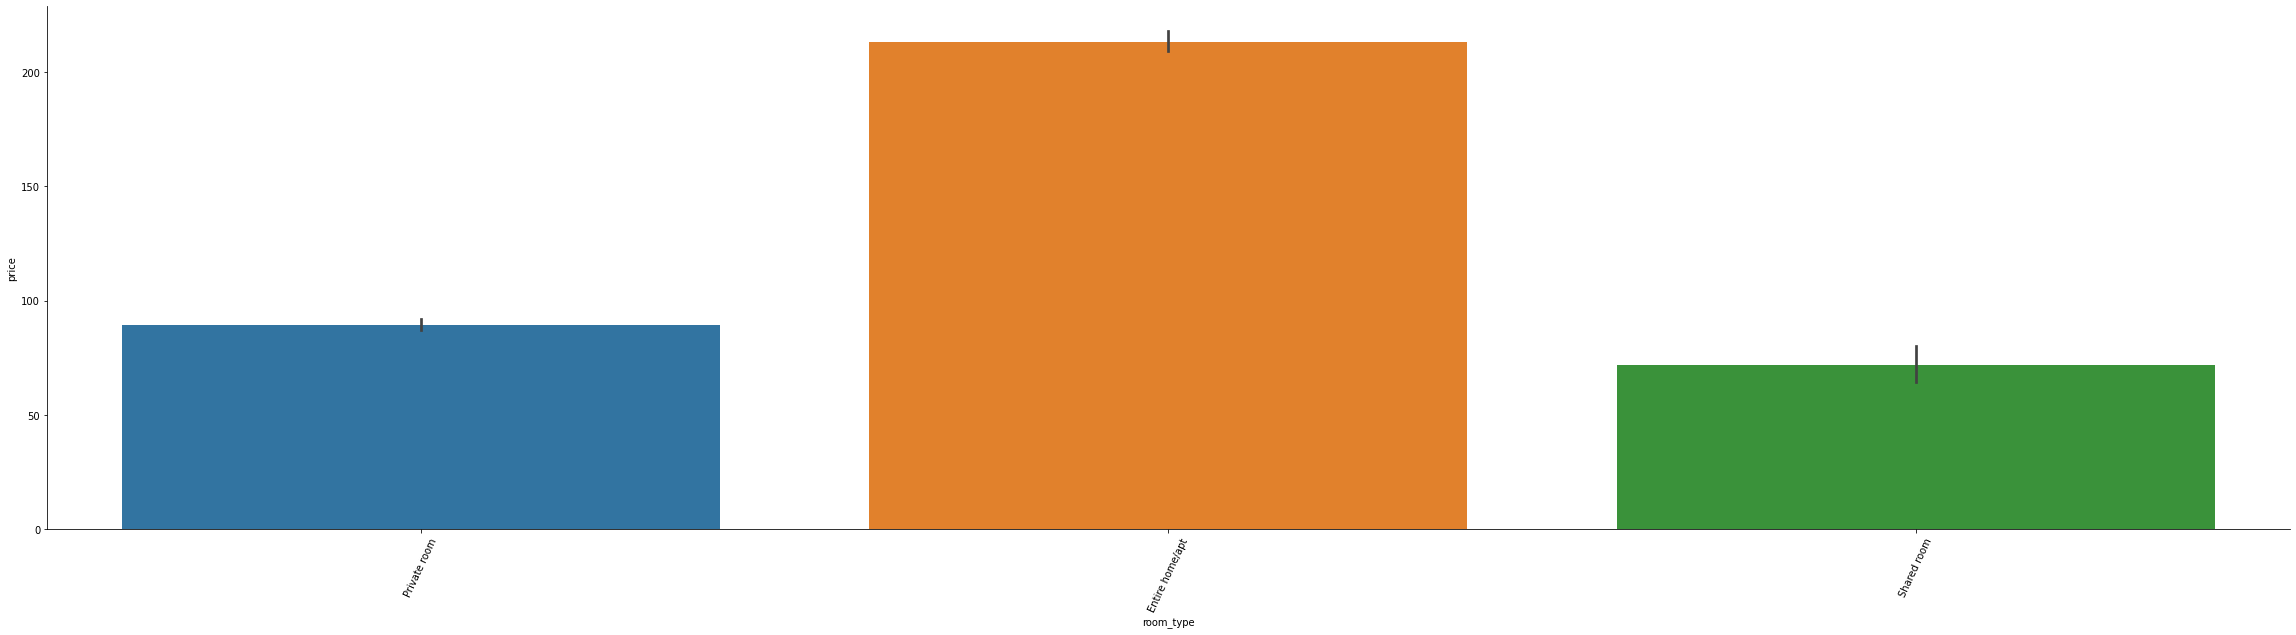

In [154]:
chart = sns.catplot(x='room_type' ,y='price', data=train , kind='bar', height=8, aspect=4,)
chart.set_xticklabels(rotation=65)
#chart.savefig('roomtype_vs_price.png',dpi=200,bbox_inches='tight')
#plt.savefig('out.png')

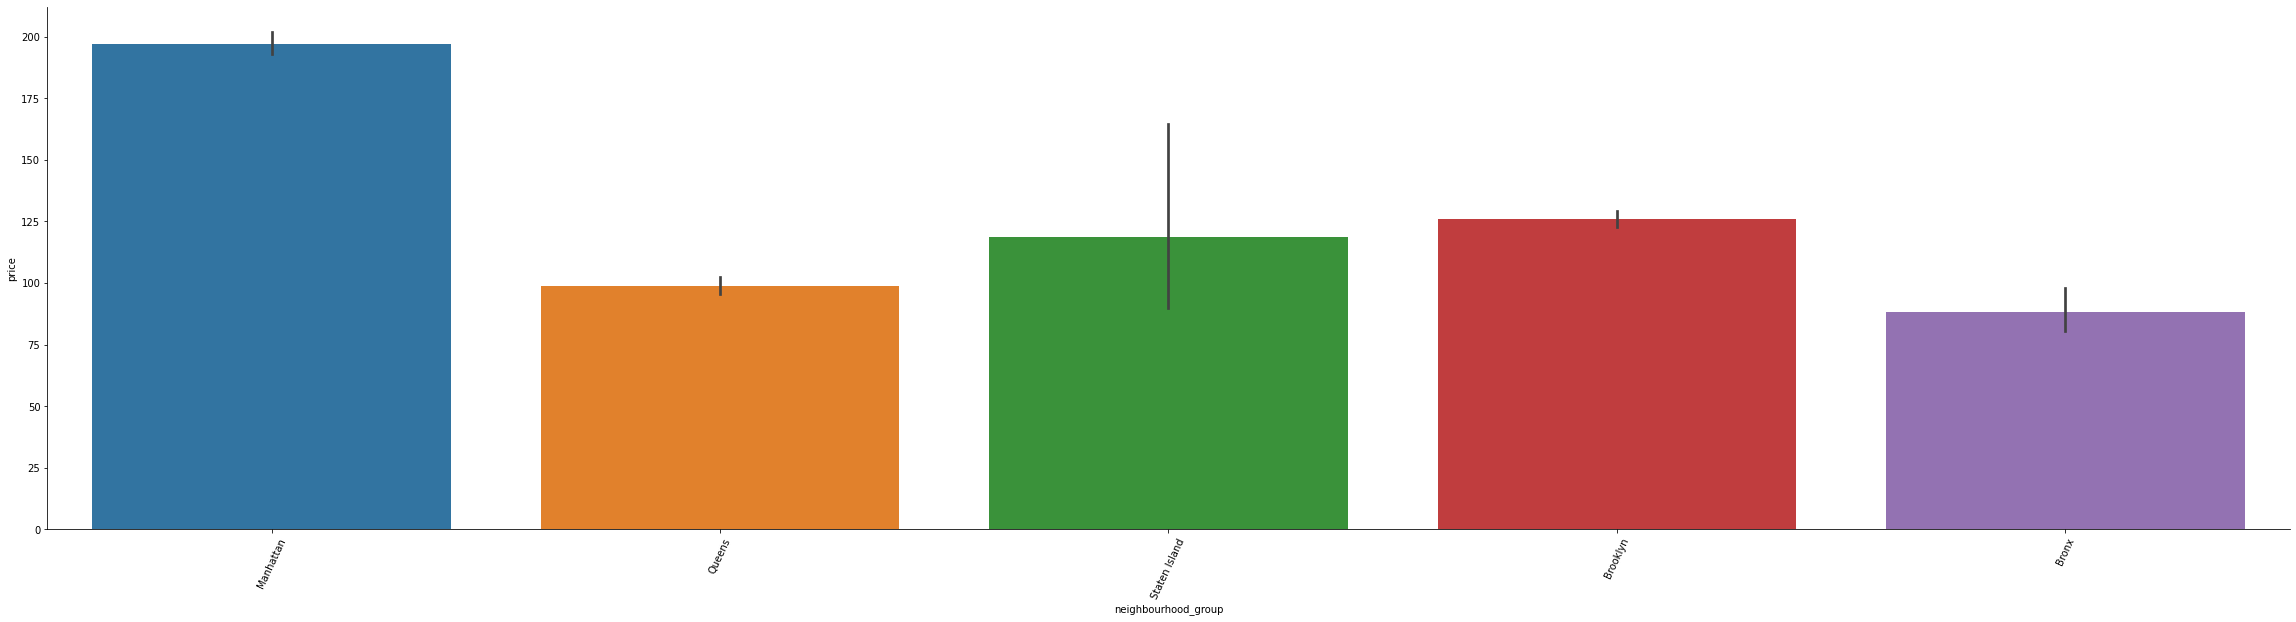

In [155]:
chart = sns.catplot(x='neighbourhood_group' ,y='price', data=train , kind='bar', height=8, aspect=4)
chart.set_xticklabels(rotation=65)
#chart.savefig('locality_vs_price.png',dpi=500,bbox_inches='tight')


<AxesSubplot:xlabel='availability_365_buckets', ylabel='price'>

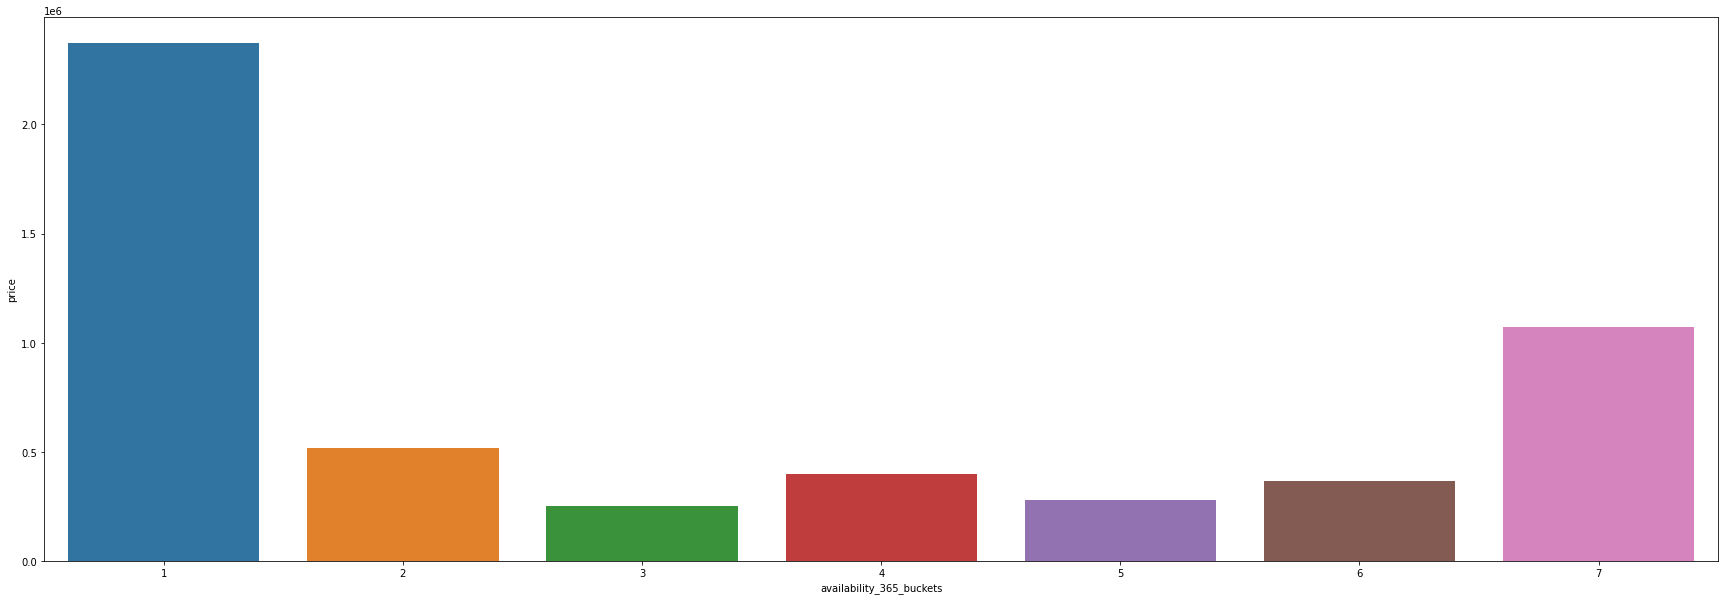

In [156]:
train.loc[train['availability_365']<train['minimum_nights'],'availability_365']=train['minimum_nights']
buckets = [0,50, 100,150, 200, 250, 300, train.availability_365.max()]
labels = [1,2,3,4, 5, 6, 7]
train['availability_365_buckets'] = pd.cut(train['availability_365'], labels=labels,bins=buckets,duplicates='drop')
data = train.groupby(['availability_365_buckets'])['price'].sum().reset_index()
plt.figure(figsize=(30,10))
sns.barplot(x= 'availability_365_buckets', y = 'price', data = data)

In [157]:
train = train.drop(['minimum_nights', 'availability_365'],1)
train.head()

,name,neighbourhood_group,neighbourhood,room_type,price,number_of_reviews,reviews_per_month,calculated_host_listings_count,minimum_nights_buckets,days_last_review,distance,availability_365_buckets
0,large private room nolita,Manhattan,Nolita,Private room,120,3,0.06,3,1,1623,3.88,1
1,super bowl new york city apartment,Manhattan,Upper West Side,Entire home/apt,1500,0,0.00,1,1,0,7.86,1
2,cozy apt close lga jfk transportation,Queens,East Elmhurst,Entire home/apt,200,4,4.00,1,1,3026,5.57,7
3,streampressed paradise laundry room setup,Staten Island,Concord,Shared room,30,0,0.00,4,1,0,17.96,2
4,charming harlem apartment,Manhattan,Harlem,Shared room,115,16,0.27,1,1,2986,8.94,7


### Converting object columns into int values

In [158]:

categorical = train.select_dtypes(include='object')
for cols in categorical:
    train[cols] =train[cols].astype('category').cat.codes
    
train['minimum_nights_buckets'] = train['minimum_nights_buckets'].astype(int)
train['availability_365_buckets'] = train['availability_365_buckets'].astype(int)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34214 entries, 0 to 34225
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            34214 non-null  int32  
 1   neighbourhood_group             34214 non-null  int8   
 2   neighbourhood                   34214 non-null  int16  
 3   room_type                       34214 non-null  int8   
 4   price                           34214 non-null  int64  
 5   number_of_reviews               34214 non-null  int64  
 6   reviews_per_month               34214 non-null  float64
 7   calculated_host_listings_count  34214 non-null  int64  
 8   minimum_nights_buckets          34214 non-null  int64  
 9   days_last_review                34214 non-null  int16  
 10  distance                        34214 non-null  float64
 11  availability_365_buckets        34214 non-null  int64  
dtypes: float64(2), int16(2), int32(1

<AxesSubplot:xlabel='distance'>

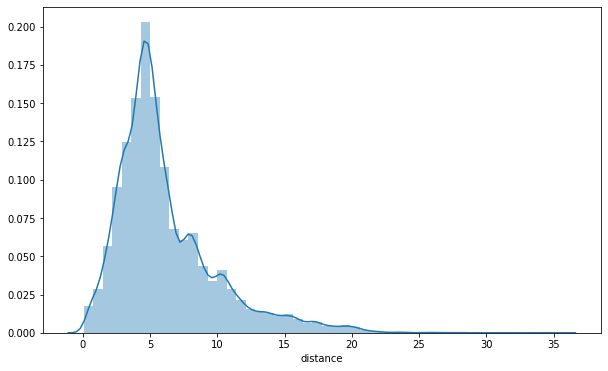

In [159]:
plt.figure(figsize=[10,6])

sns.distplot(train['distance'])

In [160]:
from scipy.stats import boxcox
train['distance'],lmbda = boxcox(train['distance'], lmbda=None)


<AxesSubplot:xlabel='distance'>

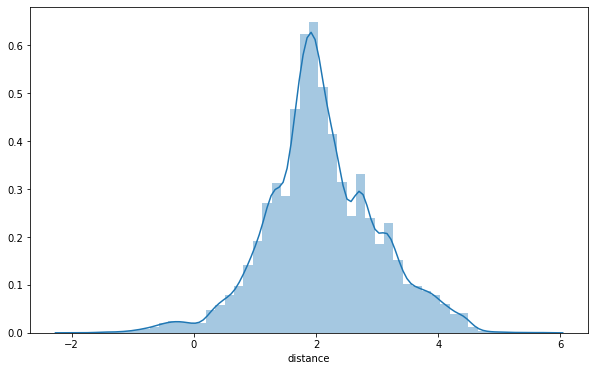

In [161]:
plt.figure(figsize=[10,6])

sns.distplot(train['distance'])

<AxesSubplot:xlabel='availability_365_buckets'>

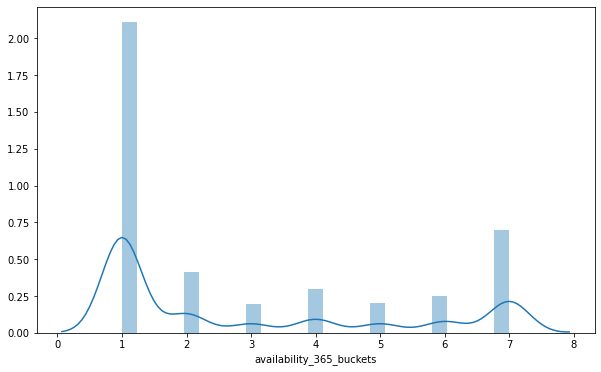

In [162]:
plt.figure(figsize=[10,6])

sns.distplot(train['availability_365_buckets'])

<AxesSubplot:xlabel='minimum_nights_buckets'>

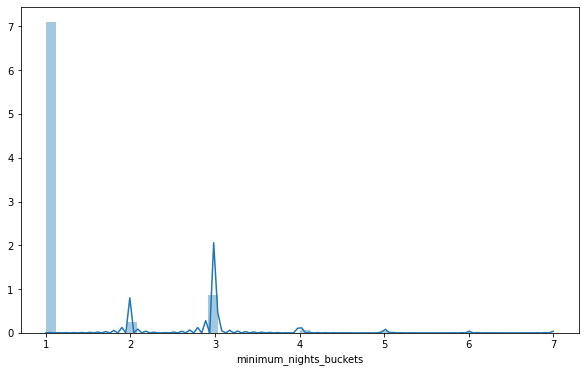

In [163]:
#checking skewness and treating them
plt.figure(figsize=[10,6])

#sns.distplot(train['name'])
sns.distplot(train['minimum_nights_buckets'])


<AxesSubplot:xlabel='number_of_reviews'>

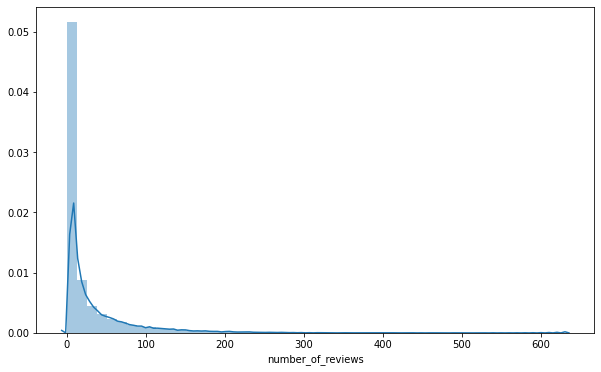

In [164]:
plt.figure(figsize=[10,6])

sns.distplot(train['number_of_reviews'])



In [165]:
train['number_of_reviews'] = np.log(train['number_of_reviews']+1)


<AxesSubplot:xlabel='number_of_reviews'>

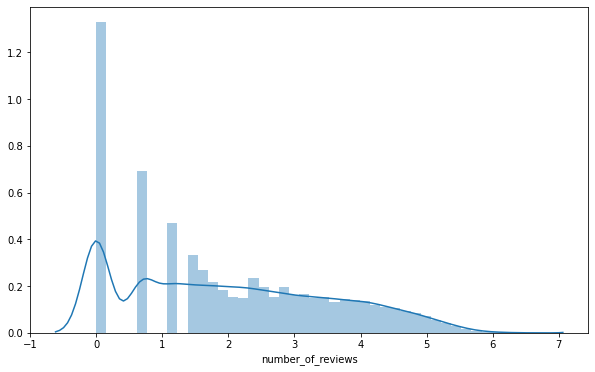

In [166]:
plt.figure(figsize=[10,6])

sns.distplot(train['number_of_reviews'])

<AxesSubplot:xlabel='reviews_per_month'>

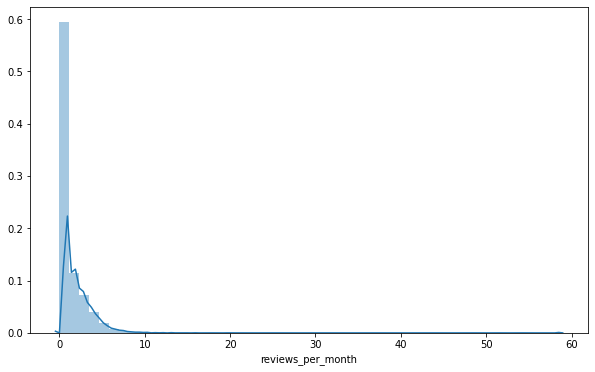

In [167]:
plt.figure(figsize=[10,6])

sns.distplot(train['reviews_per_month'])

In [168]:
train['reviews_per_month'] = np.log(train['reviews_per_month']+1)


<AxesSubplot:xlabel='reviews_per_month'>

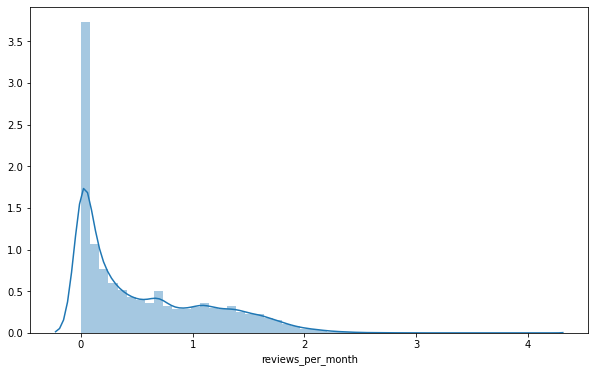

In [169]:
plt.figure(figsize=[10,6])

sns.distplot(train['reviews_per_month'])

<AxesSubplot:xlabel='calculated_host_listings_count'>

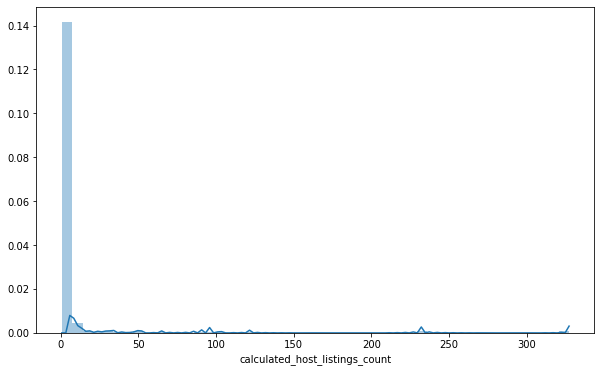

In [170]:
plt.figure(figsize=[10,6])

sns.distplot(train['calculated_host_listings_count'])

In [171]:
train['calculated_host_listings_count'] = np.log(train['calculated_host_listings_count']+1)

<AxesSubplot:xlabel='calculated_host_listings_count'>

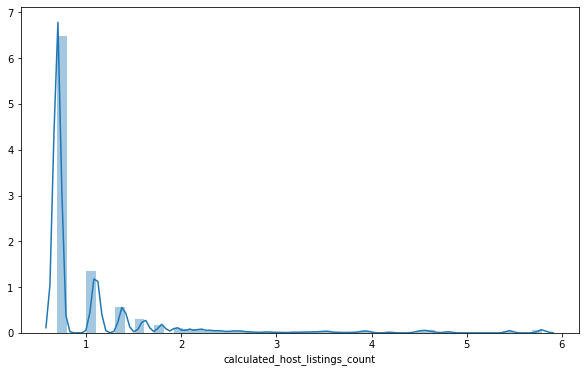

In [172]:
plt.figure(figsize=[10,6])

sns.distplot(train['calculated_host_listings_count'])

### Imputing columns with price 0 with median value

In [173]:
train['price'] = train['price'].replace(0,np.nan)
train['price'] = train['price'].fillna(train.groupby('neighbourhood')['price'].transform('median'))

### Looking for correlation if any among the features

<AxesSubplot:>

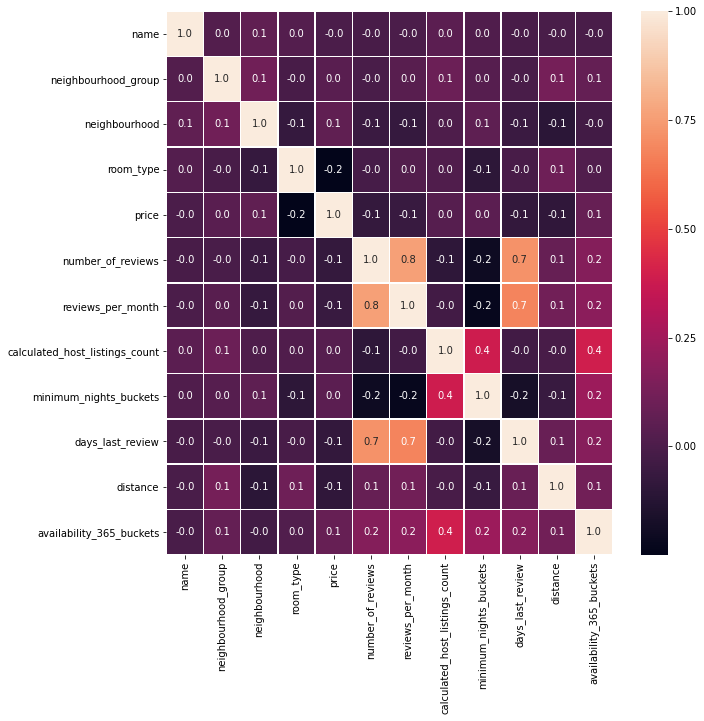

In [174]:
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(train.corr(),annot=True, linewidths=.5, fmt= '.1f',ax=ax)

### Plotting scatter plots to look for any correlation among the columns

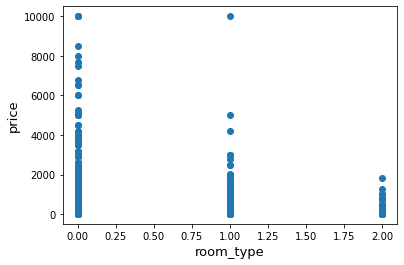

In [175]:
fig, ax = plt.subplots()
ax.scatter(x = train['room_type'], y = train['price'])
plt.ylabel('price', fontsize=13)
plt.xlabel('room_type', fontsize=13)
plt.show()

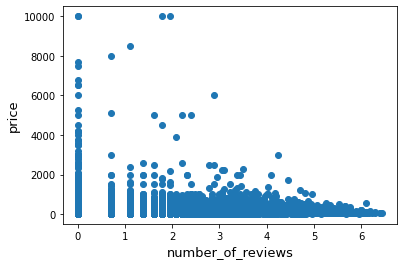

In [176]:
fig, ax = plt.subplots()
ax.scatter(x = train['number_of_reviews'], y = train['price'])
plt.ylabel('price', fontsize=13)
plt.xlabel('number_of_reviews', fontsize=13)
plt.show()

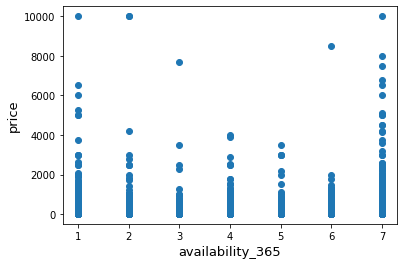

In [177]:
fig, ax = plt.subplots()
ax.scatter(x = train['availability_365_buckets'], y = train['price'])
plt.ylabel('price', fontsize=13)
plt.xlabel('availability_365', fontsize=13)
plt.show()

### Normalising the Price column and trying to reduce skewness


 mu = 153.51 and sigma = 243.33



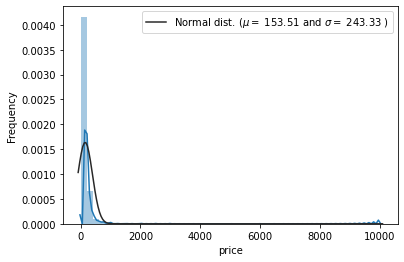

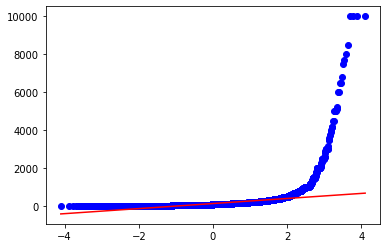

In [178]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

sns.distplot(train['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')


#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['price'], plot=plt)
plt.show()


 mu = 4.74 and sigma = 0.69



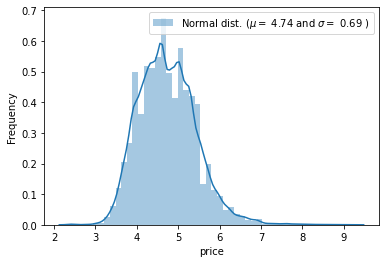

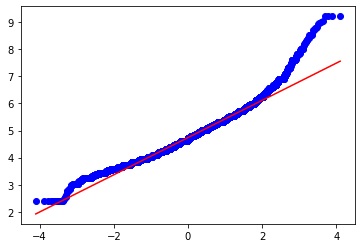

In [179]:
train["price"] = np.log1p(train["price"])

#Check the new distribution 
sns.distplot(train['price']);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')


#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['price'], plot=plt)
plt.show()

### Splitting dataset and creating Train and Test sets.

In [180]:
X = train.drop('price',1)
y = train['price']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

### Checking number of optimum features for modelling

In [181]:
from sklearn.feature_selection import RFECV

rf = RandomForestRegressor(random_state=43) 
rfecv = RFECV(estimator=rf, step=1, cv=5,scoring=scorer)   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 11
Best features : Index(['name', 'neighbourhood_group', 'neighbourhood', 'room_type',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'minimum_nights_buckets',
       'days_last_review', 'distance', 'availability_365_buckets'],
      dtype='object')


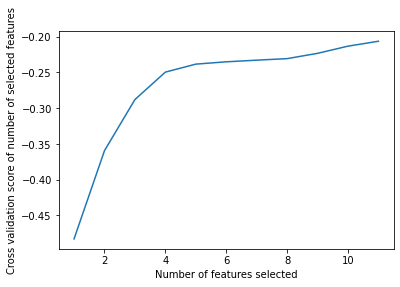

In [182]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

### Modelling starts here

In [183]:
#LinearRegression Model

lmodel = LinearRegression()
lmodel.fit(X_train, y_train)

linearmo = lmodel.predict(X_test)
lrmse = np.sqrt(mean_squared_error(y_test, linearmo))
print(lrmse)
lin_acc = r2_score(y_test, linearmo)
lin_acc

0.5162998193090329


0.4479529000615443

In [184]:
#LinearRegression model with hyperparameter tuning

parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}

model = LinearRegression()
grid = GridSearchCV(model,parameters)

grid.fit(X_train, y_train)

pred = grid.predict(X_test)

square = mean_squared_error(y_test, pred)
rmse_2 = np.sqrt(square)
print(rmse_2)

raccuracy= r2_score(y_test, pred)
print(raccuracy)



0.5162998193090329
0.4479529000615443


In [185]:
# plain RandomForestRegressor model

rf_clf1 = RandomForestRegressor(max_depth=2, random_state=2)
rf_clf1.fit(X_train, y_train)

prediction1 = rf_clf1.predict(X_test)


rf_square = mean_squared_error(y_test, prediction1)
rmse_rd = np.sqrt(rf_square)
print(rmse_rd)

rfaccuracy= r2_score(y_test, prediction1)
print(rfaccuracy)

0.5283613281911412
0.42185838258450703


In [186]:
#Modeling on linearRegression with PolynomialFeatures

from sklearn.preprocessing import PolynomialFeatures

polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(X_train)

model.fit(x_poly,y_train)

x_testp = polynomial_features.fit_transform(X_test)
predd = model.predict(x_testp)

square = mean_squared_error(y_test, predd)
rmse_3 = np.sqrt(square)
print(rmse_3)

rs_accuracy= r2_score(y_test, predd)
rs_accuracy


0.48621734550532225


0.5104093868159911

In [187]:
##Lasso and Ridge with Hyperparameter tuning

lasso_lambdas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1]

lasso_model = Lasso()
lasso_grid = GridSearchCV(lasso_model, param_grid=dict(alpha=lasso_lambdas), scoring=scorer ,cv=10)

lasso_grid.fit(X_train, y_train)
ls_pred = lasso_grid.predict(X_test)

lasso_rmse = np.sqrt(mean_squared_error(ls_pred, y_test))

print(lasso_rmse)
r2_score(ls_pred, y_test)

0.5162915213819385


-0.22550766314588988

In [188]:
ridge_lambdas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60]

ridge_model = Ridge()
Ridge_grid = GridSearchCV(ridge_model, param_grid=dict(alpha=ridge_lambdas), scoring=scorer )

Ridge_grid.fit(X_train, y_train)
rg_pred = Ridge_grid.predict(X_test)

ridge_rmse = np.sqrt(mean_squared_error(rg_pred, y_test))

print(ridge_rmse)
r2_score(rg_pred, y_test)

0.5162975105154696


-0.22494970176130002

In [189]:
#Modeling with standardisation of data

from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()

X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled= scaler.transform(X_test)

rf = RandomForestRegressor(max_depth=2, random_state=1)
rf.fit(X_train_scaled, y_train)

scaled_pred = rf.predict(X_test_scaled)

rff_rmse = np.sqrt(mean_squared_error(scaled_pred, y_test))
rff_rmse

0.5285573093255069

In [190]:
#Modelling with DecisionTreeRegressor

from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state = 4, max_depth=2)
dt.fit(X_train, y_train)
dtpredict = dt.predict(X_test)

dtrmse = np.sqrt(mean_squared_error(dtpredict, y_test))
dtrmse

r2_score(dtpredict, y_test)

-0.4052418637292725

In [191]:
#Trying XGBoost

import xgboost as xgb
from xgboost.sklearn import XGBRegressor

xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:   43.7s finished


[20:49:26] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:49:26] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:49:31] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_

In [192]:
XGBPred = xgb_grid.predict(X_test)
XGB_rmse = np.sqrt(mean_squared_error(XGBPred, y_test))
print(XGB_rmse)
r2_score(XGBPred, y_test)

0.4350373242270528


0.3474064085435721

In [193]:
# Stacking Modelling

from mlxtend.regressor import StackingRegressor

classifier1 = LinearRegression()
classifier2= DecisionTreeRegressor(random_state=21)
classifier3 = Lasso(random_state=22)
classifier4= Ridge(random_state=23)
classifier5 = RandomForestRegressor(random_state=44)
classifier_list=[classifier1, classifier2, classifier3, classifier4, classifier5]

m_classifier=RandomForestRegressor(random_state=30)

# Code starts here
stack = StackingRegressor(regressors=classifier_list, meta_regressor=m_classifier)
stack.fit(X_train, y_train)
s_score = stack.predict(X_test)

stack_rmse = np.sqrt(mean_squared_error(y_test,s_score))
stack_rmse

0.6292033047642739

In [194]:
# GradientBoostingRegressor modelling

from sklearn.ensemble import GradientBoostingRegressor

gb_clf = GradientBoostingRegressor(random_state=0)

gb_clf.fit(X_train, y_train)
gb_score = gb_clf.predict(X_test)

rmsee = np.sqrt(mean_squared_error(y_test, gb_score))
print(rmsee)

r2_score(y_test, gb_score)

0.4562124487167438


0.5689710404227013

In [ ]:
#Trying SVR

from sklearn.svm import SVR

svr_regressor = SVR(kernel='rbf')
svr_regressor.fit(X_train, y_train)
#5 Predicting a new result
y_pred_svr = svr_regressor.predict(X_test)
svr_rmse = np.sqrt(mean_squared_error(y_pred_svr, y_test))
print(svr_rmse)

r2_score(y_pred_svr, y_test)

# Loading Test data and performing all above operations


In [ ]:
test = pd.read_csv('Test.csv')
test.head()

In [ ]:
updated_test = test.drop(['id','host_id','host_name'],1)
updated_test.isnull().sum()

In [ ]:
updated_test.describe()

In [ ]:
updated_test['reviews_per_month'] = updated_test['reviews_per_month'].fillna(0)
updated_test['last_review'] = updated_test['last_review'].fillna('2011-03-23')

updated_test['days_last_review'] = (pd.DatetimeIndex(updated_test['last_review']) - pd.to_datetime('2011-03-23')).astype('str')
updated_test['days_last_review'] = (updated_test['days_last_review'].apply(lambda x : x.split(" ")[0]))


In [ ]:
# The math module contains a function named
# radians which converts from degrees to radians.

from math import radians, cos, sin, asin, sqrt
def distance(lati1, lati2, long1, long2):
   
  long1 = radians(long1)
  long2 = radians(long2)
  lati1 = radians(lati1)
  lati2 = radians(lati2)
   
  # Haversine formula
  dlong = long2 - long1
  dlati = lati2 - lati1
  a = sin(dlati / 2)**2 + cos(lati1) * cos(lati2) * sin(dlong / 2)**2

  c = 2 * asin(sqrt(a))
 
  # Radius of earth in kilometers. Use 3956 for miles
  r = 6371
   
  # calculate the result
  return(c * r)
# print(distance(lati1, lati2, long1, long2), "K.M")
lati2 =round(updated_test.latitude.values.mean(),2)
long2=round(updated_test.longitude.values.mean(),2)
distt= []
for index,row in updated_test.iterrows():
#     distance(row.latitude,lat2,row.longitude,lon2)
   distt.append(distance(row.latitude,lati2,row.longitude,long2))

#distance =distance(df.latitude.values,lat2,  df.longitude.values, df.longitude.values.mean())
updated_test['distance_1']= pd.Series(dist)
updated_test['distance_1'] = round(updated_test['distance_1'],2)


In [ ]:
updated_test['name'] = updated_test['name'].fillna(method='ffill')
updated_test.isnull().sum()

In [ ]:
updated_test['name'] = updated_test['name'].str.lower()

import string

def remove_punctuation(text):
    no_punct = "".join([c for c in text if c not in string.punctuation])
    return no_punct

updated_test['name'] = updated_test['name'].apply(lambda x:remove_punctuation(x))

def tok(text):
    tokenizer = word_tokenize(text)
    return tokenizer

updated_test['name'] = updated_test['name'].apply(lambda x:tok(x))    

def remove_stop_words(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

updated_test['name'] = updated_test['name'].apply(lambda x:remove_stop_words(x))

def join(text):
    joined = " ".join(text)
    return joined

updated_test['name'] = updated_test['name'].apply(lambda x:join(x))


In [ ]:
buckets = [0,7, 14,30, 60, 120, 240, test.minimum_nights.max()]
labels = [1,2,3,4, 5, 6, 7]
updated_test['minimum_nights_buckets'] = pd.cut(updated_test['minimum_nights'], bins=buckets, labels=labels)

In [ ]:
updated_test.loc[updated_test['availability_365']<updated_test['minimum_nights'],'availability_365']=updated_test['minimum_nights']
buckets = [0,50, 100,150, 200, 250, 300, updated_test.availability_365.max()]
labels = [1,2,3,4, 5, 6, 7]
updated_test['availability_365_buckets'] = pd.cut(updated_test['availability_365'], labels=labels,bins=buckets,duplicates='drop')

In [ ]:
updated_test

In [ ]:
updated_test = updated_test.drop(['last_review','longitude','latitude','minimum_nights', 'availability_365'],1)


In [ ]:
categorical = updated_test.select_dtypes(include='object')
for cols in categorical:
    updated_test[cols] =updated_test[cols].astype('category').cat.codes
    
updated_test['minimum_nights_buckets'] = updated_test['minimum_nights_buckets'].astype(int)

In [ ]:
updated_test['distance_1'],lmbda = boxcox(updated_test['distance_1'], lmbda=None)


In [ ]:
colss = ['number_of_reviews','reviews_per_month','calculated_host_listings_count']

for i in colss:
    updated_test[i] = np.log(updated_test[i]+1)

In [ ]:
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(updated_test.corr(),annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [ ]:
final_pred = gb_clf.predict(updated_test)
output = pd.DataFrame({'id': test.id, 'price': np.expm1(final_pred)})
output.to_csv('TEAM_4.csv', index=False)
output